<a href="https://colab.research.google.com/github/huytrinhx/lda-topic-modelling/blob/main/Predicting_the_usefulness_of_Amazon_Reviews_Base_Train(LDA%2BJSD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up

Mount google drive to save data and models to local google drive folder

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
home_dir = '/content/gdrive/MyDrive/Data/'
data_dir = home_dir+'US_Tennis_Racquet_Reviews_Dataset.csv'

In [3]:
import numpy as np #for matrix operations
import tensorflow as tf #general tensorflows to work with amazon datasets
import tensorflow_hub as hub 
import tensorflow_datasets as tfds
import pandas as pd # for data tables manipulation
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for more fancy visualization

!pip install nltk
import nltk # library to clean and preprocess text
nltk.download("stopwords")
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
!pip install stop_words
from stop_words import get_stop_words

import gensim # library to run LDA algorithms
from gensim import corpora, models
import operator # for list operations
import pickle # for saving model and data
import random # for random generators
!pip install pyLDAvis
import pyLDAvis.gensim # for visualize LDA output
from scipy.spatial import distance # calculate Janson-Shannon Distance
from sklearn.preprocessing import MinMaxScaler # Rescale useful votes count 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # report classficiation metrics
import warnings #ignore warnings
warnings.filterwarnings('ignore')
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32919 sha256=26f25ca336c49052c3b2d26c39394ee80de8871d6f07c5bb07d42afd9eea2353
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words
     |████████████████████████████████| 1.6MB 10.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=1faab4bd8160ab3c779828b39fcf20b1456739e23bbb6b51e0d9cbec29f955e0
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis
Version:  2.4.0
Eager mode:  True
Hub version:  0.10.0
GPU is available


#Download the dataset (Amazon Reviews/Sports)

* Change the dataset name if your scope is different
* Only do this once and save to local drive because loading the dataset the first time is very time-consuming

In [ ]:
ds, info = tfds.load(name="amazon_us_reviews/Sports_v1_00", 
                        shuffle_files=True,
                        with_info=True)
print(ds)
print(info)

Filter data for only products related to tennis racqet (US market)

In [ ]:
ds_US = ds['train'].filter(lambda x: x['data']['marketplace'] == 'US')

In [ ]:
ds_Tennis = ds_US.filter(lambda x: tf.strings.regex_full_match(tf.strings.lower(x['data']['product_title']),".*tennis.*"))

In [ ]:
ds_Racquet = ds_Tennis.filter(lambda x: tf.strings.regex_full_match(tf.strings.lower(x['data']['product_title']),".*racquet.*"))

In [ ]:
tfds.as_dataframe(ds_Racquet.take(5))

Convert dataset to pandas dataframe:

In [ ]:
tennis_racquet_df = tfds.as_dataframe(ds_Racquet)
print(len(tennis_racquet_df))

In [ ]:
tennis_racquet_df.to_csv(data_dir)

#Load data from local drive

In [135]:
data = pd.read_csv(data_dir)
data.head(5)

,Unnamed: 0,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine
0,0,b'20515499',1,b'US',b'Sports',b'B000OQ74FE',b'447336068',"b'HEAD Liquidmetal 4 Tennis Racquet (4-3/8), S...","b""Supposedly one of the best novice racquets. ...",b'2012-12-30',b'highly rated',b'R12VYI1R99EI1Q',5,4,0,1
1,1,b'33855426',1,b'US',b'Sports',b'B0034PBLA6',b'16849618',b'Wilson Energy Extra Large Tennis Racquet wit...,b'Wilson Energy Extra Large Tennis Racquet wit...,b'2012-10-02',b'Wilson Energy Extra Large Tennis Racquet wit...,b'R31ZPNKKOSMF2L',3,5,0,1
2,2,b'48169106',0,b'US',b'Sports',b'B006A2V4KC',b'81787317',b'Head Youtek IG Prestige Pro Tennis Racquet (...,"b""I've been playing with Head Racquets for man...",b'2014-12-21',b'Best of the Prestige frames',b'R2NOC0IE7BEWWN',5,0,0,1
3,3,b'31282127',0,b'US',b'Sports',b'B000OQBP7C',b'384056751',b'Head Liquidmetal 8 Tennis Racquet',b'I chose this racquet because its price and w...,b'2013-07-08',b'Great!!!',b'R2IDP12RDJ1SB5',5,1,0,1
4,4,b'7692919',1,b'US',b'Sports',b'B004IA8GL8',b'586581984',"b""Wilson unstrung'11 Blade Lite BLX Tennis Rac...",b'The racket is really nice for $60+. There is...,b'2013-07-14',b'Good racket',b'R2VG95KHXUZG1S',4,1,0,1


# Data Exploration

* Number of products in the dataset
* Number reviews for each

In [6]:
cols = ['data/helpful_votes','data/product_id','data/product_parent',
        'data/product_title','data/review_body','data/review_headline','data/review_id',
        'data/star_rating', 'data/total_votes']
data = data[cols]
data.head(5)

,data/helpful_votes,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_headline,data/review_id,data/star_rating,data/total_votes
0,1,b'B000OQ74FE',b'447336068',"b'HEAD Liquidmetal 4 Tennis Racquet (4-3/8), S...","b""Supposedly one of the best novice racquets. ...",b'highly rated',b'R12VYI1R99EI1Q',5,4
1,1,b'B0034PBLA6',b'16849618',b'Wilson Energy Extra Large Tennis Racquet wit...,b'Wilson Energy Extra Large Tennis Racquet wit...,b'Wilson Energy Extra Large Tennis Racquet wit...,b'R31ZPNKKOSMF2L',3,5
2,0,b'B006A2V4KC',b'81787317',b'Head Youtek IG Prestige Pro Tennis Racquet (...,"b""I've been playing with Head Racquets for man...",b'Best of the Prestige frames',b'R2NOC0IE7BEWWN',5,0
3,0,b'B000OQBP7C',b'384056751',b'Head Liquidmetal 8 Tennis Racquet',b'I chose this racquet because its price and w...,b'Great!!!',b'R2IDP12RDJ1SB5',5,1
4,1,b'B004IA8GL8',b'586581984',"b""Wilson unstrung'11 Blade Lite BLX Tennis Rac...",b'The racket is really nice for $60+. There is...,b'Good racket',b'R2VG95KHXUZG1S',4,1


In [7]:
float_cols = ['data/helpful_votes','data/total_votes']
cat_cols = ['data/product_id','data/product_parent','data/product_title','data/star_rating']

def visualize_columns(float_cols,cat_cols):
    '''
    This function visualizes all columns
      - Box-and-whisker and histogram plots for continuous variables
      - Lists of distinct values for categorical columns
    '''
    # Float columns
    for i in float_cols:
        print(i)
        fig, axs = plt.subplots(1, 2, tight_layout=True)

        sns.boxplot(data=final_data[i], ax = axs[0])

        # Print the three highest values
        highest_vals = sorted(final_data[i], reverse=True)[:3]
        print(highest_vals)
        smallest_val = round(min(final_data[i]),2)
        print(smallest_val)
        axs[0].text(smallest_val, -0.3, round(highest_vals[0],2))
        axs[0].text(smallest_val, -0.2, round(highest_vals[1],2))
        axs[0].text(smallest_val, -0.1, round(highest_vals[2],2))

        #Draw the histogram
        axs[1] = plt.hist(final_data[i],50)
        plt.show()
        
    # Categorical columns 
    for i in cat_cols:
        print(i)
        print(str(len(set(final_data[i]))) + " distinct values")
        print(final_data[i].value_counts())
        print("")
        print("")

data/helpful_votes
[595, 171, 101]
0


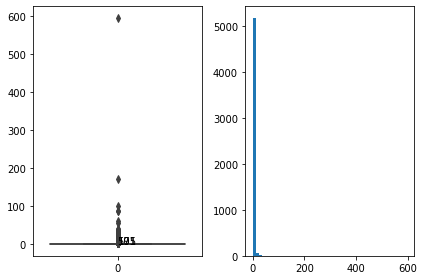

data/total_votes
[598, 177, 105]
0


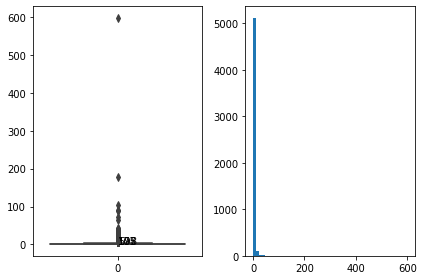

data/product_id
2186 distinct values
b'B00387ET9A'    133
b'B0007R8MHE'     95
b'B007WZZ3TE'     92
b'B000KYHMM0'     51
b'B0034PBLA6'     50
                ... 
b'B0000AQA5Y'      1
b'B0009GUCBM'      1
b'B000V6WV5A'      1
b'B00HQE7ZHE'      1
b'B00GFYRIYG'      1
Name: data/product_id, Length: 2186, dtype: int64


data/product_parent
1602 distinct values
b'453459277'    159
b'245257838'    133
b'384056751'    117
b'33077627'     111
b'547332048'    109
               ... 
b'72297323'       1
b'367147621'      1
b'914175674'      1
b'979916381'      1
b'678814265'      1
Name: data/product_parent, Length: 1602, dtype: int64


data/product_title
1601 distinct values
b'Wilson US Open Junior Tennis Racquet'                                                                                                                                                                    159
b'Wilson Advantage Triple Tennis Racquet Bag (Black\\Gray)'                                                         

In [8]:
final_data = data
visualize_columns(float_cols,cat_cols)

In [9]:
#Aggregating count of reviews and total helpful votes for each products
products = final_data.groupby('data/product_parent', sort=False)
combined = products['data/helpful_votes'].agg(['count', 'sum'])
combined.sort_values(by='sum',ascending=False)

,count,sum,min,max
data/product_parent,,,,
b'453459277',159,1016,0,595
b'384056751',117,227,0,101
b'547332048',109,201,0,89
b'33077627',111,193,0,21
b'630149495',9,190,3,62
...,...,...,...,...
b'981876364',1,0,0,0
b'407107768',1,0,0,0
b'201894283',2,0,0,0


In [10]:
selected_products = combined[combined['sum'] > 0]
left = pd.DataFrame(selected_products)

final_data = final_data.merge(selected_products, on='data/product_parent', how='left')
final_data.head()

,data/helpful_votes,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_headline,data/review_id,data/star_rating,data/total_votes,count,sum,min,max
0,1,b'B000OQ74FE',b'447336068',"b'HEAD Liquidmetal 4 Tennis Racquet (4-3/8), S...","b""Supposedly one of the best novice racquets. ...",b'highly rated',b'R12VYI1R99EI1Q',5,4,22.0,38.0,0.0,10.0
1,1,b'B0034PBLA6',b'16849618',b'Wilson Energy Extra Large Tennis Racquet wit...,b'Wilson Energy Extra Large Tennis Racquet wit...,b'Wilson Energy Extra Large Tennis Racquet wit...,b'R31ZPNKKOSMF2L',3,5,86.0,114.0,0.0,24.0
2,0,b'B006A2V4KC',b'81787317',b'Head Youtek IG Prestige Pro Tennis Racquet (...,"b""I've been playing with Head Racquets for man...",b'Best of the Prestige frames',b'R2NOC0IE7BEWWN',5,0,5.0,8.0,0.0,6.0
3,0,b'B000OQBP7C',b'384056751',b'Head Liquidmetal 8 Tennis Racquet',b'I chose this racquet because its price and w...,b'Great!!!',b'R2IDP12RDJ1SB5',5,1,117.0,227.0,0.0,101.0
4,1,b'B004IA8GL8',b'586581984',"b""Wilson unstrung'11 Blade Lite BLX Tennis Rac...",b'The racket is really nice for $60+. There is...,b'Good racket',b'R2VG95KHXUZG1S',4,1,6.0,6.0,0.0,2.0


In [11]:
#Remove reviews from products that does not have any helpful votes
df = final_data[final_data['sum'] > 0]
print('Number of reviews removed: '+ str(len(final_data)-len(df)))

Number of reviews removed: 1036


In [12]:
#Remove reviews that does not have any helpful votes
df_1 = final_data[final_data['data/helpful_votes'] > 0]
print(df_1['data/review_body'].head())
print('Number of reviews removed: '+ str(len(final_data)-len(df_1)))

0    b"Supposedly one of the best novice racquets. ...
1    b'Wilson Energy Extra Large Tennis Racquet wit...
4    b'The racket is really nice for $60+. There is...
5    b"Perfect size and weight for the child's stre...
8    b'As expected, powerful yet controlled. I play...
Name: data/review_body, dtype: object
Number of reviews removed: 3170


In [13]:
#Checking if there are any factors that make up the data
df_2 = df[df['data/helpful_votes'] > 0]
print('Number of reviews removed: '+ str(len(df)-len(df_2)))

Number of reviews removed: 2134


#Tokenization

In [20]:
tokenizer = RegexpTokenizer(r'\w+')

#Stopping

In [21]:
nltk_stpwd = stopwords.words('english')
stop_words_stpwd = get_stop_words('en')
custom_stpwd = ['b','br',] # These get added after inspecting the listing of stemmed tokens
merged_stopwords = list(set(nltk_stpwd + stop_words_stpwd + custom_stpwd))

print(len(set(merged_stopwords)))
print(merged_stopwords[:10])

213
['do', 'yourself', 'these', "where's", 'for', "he'd", 'an', 'its', 'him', 'from']


#Stemming

In [22]:
sb_stemmer = SnowballStemmer('english')

# Transform Reviews Text to Term Frequency - IDF Vector

In [23]:
def tokenize_stop_stem_text(document):
  tokens = tokenizer.tokenize(document.lower())
  stopped_tokens = [token for token in tokens if not token in merged_stopwords]
  stemmed_tokens = [sb_stemmer.stem(token) for token in stopped_tokens]
  return stemmed_tokens

In [140]:
train_df = df_1
num_reviews = train_df.shape[0]
# Stripping leading and trailing characters
train_df['data/review_body'] = train_df['data/review_body'].str.strip("b\'\"")
# Removing any digits
train_df['data/review_body'] = train_df['data/review_body'].str.replace(r'\d+','')
# Load reviews into list
doc_set = [train_df['data/review_body'].iloc[i] for i in range(num_reviews)]
texts = []

for doc in doc_set:
  # putting our three steps together
  results = tokenize_stop_stem_text(doc)
  #print(stemmed_tokens) #Uncomment to inspect the results of tokenizations
  # add tokens to list
  texts.append(results)

print(texts[0])

['suppos', 'one', 'best', 'novic', 'racquet', 'bought', 'daughter', 'birthday', 'degre', 'outsid', 'ask', 'next', 'summer']


In [25]:
# Gensim's Dictionary encapsulates the mapping between normalized words and their integer ids.
texts_dict = corpora.Dictionary(texts)
# Examine each token’s unique id
print(texts_dict)

Dictionary(4656 unique tokens: ['ask', 'best', 'birthday', 'bought', 'daughter']...)


In [26]:
LOWER_BOUND = 5
UPPER_BOUND = 0.25
texts_dict.filter_extremes(no_below=LOWER_BOUND, no_above=UPPER_BOUND) # inplace filter
print(texts_dict)
print("top terms:")
print(sorted(texts_dict.token2id.items(), key=operator.itemgetter(1), reverse = False)[:10])

Dictionary(1485 unique tokens: ['ask', 'best', 'birthday', 'bought', 'daughter']...)
top terms:
[('ask', 0), ('best', 1), ('birthday', 2), ('bought', 3), ('daughter', 4), ('degre', 5), ('next', 6), ('novic', 7), ('outsid', 8), ('summer', 9)]


In [136]:
texts_dict.save(home_dir+'tennis_racquet_review.dict') # lets save to disk for later use

In [29]:
corpus = [texts_dict.doc2bow(text) for text in texts]
len(corpus)
pickle.dump(corpus, open(home_dir+'tennis_racquet_review.pkl', 'wb'))

#Train LDA Model

In [33]:
def train_LDA(corpus,dictionary,NUM_TOPICS=1,new_train=True):
  MDL = 'model{0}.gensim'.format(NUM_TOPICS)
  if new_train:
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, 
                                              id2word=dictionary, passes=15,iterations=5000, # to make sure enough random starts
                                              random_state=random.seed(12345), # to make sure results are the same every run
                                              minimum_probability=0.0001) #to make sure no topics are filtered out
    ldamodel.save(home_dir+MDL)
  else:
    ldamodel = gensim.models.ldamodel.LdaModel.load(home_dir+MDL)

  #Print top 10 words from each topics
  topics = ldamodel.print_topics(num_words=10)
  for topic in topics:
      print(topic)
  #Visualize LDA results
  lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
  pyLDAvis.display(lda_display)

In [137]:
k=4
train_LDA(corpus,texts_dict,k,True)

(0, '0.033*"frame" + 0.024*"spin" + 0.017*"power" + 0.017*"player" + 0.015*"serv" + 0.014*"shot" + 0.011*"string" + 0.011*"make" + 0.011*"like" + 0.011*"hit"')
(1, '0.037*"string" + 0.015*"time" + 0.014*"get" + 0.013*"well" + 0.013*"year" + 0.012*"light" + 0.012*"price" + 0.012*"first" + 0.011*"klipperm" + 0.011*"easi"')
(2, '0.013*"wilson" + 0.012*"like" + 0.011*"string" + 0.011*"control" + 0.010*"feel" + 0.010*"tri" + 0.009*"bought" + 0.009*"two" + 0.009*"new" + 0.008*"weight"')
(3, '0.019*"bag" + 0.017*"year" + 0.017*"raquet" + 0.016*"look" + 0.014*"old" + 0.014*"nice" + 0.014*"like" + 0.013*"player" + 0.013*"love" + 0.013*"string"')


# Training the LDA models with different values of K (Number of topics as assumptions)

# Create Our Target Variable: Determine the right metrics for usefulness

helpful_votes_scaled
[0.5, 0.5, 0.16666666666666666]
0.0


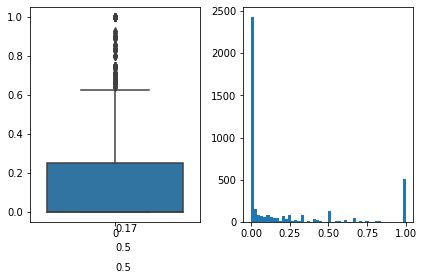

data/helpful_votes
[595, 171, 101]
0


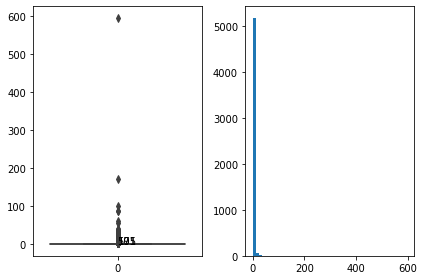

sum
[227.0, 201.0, 193.0]
1.0


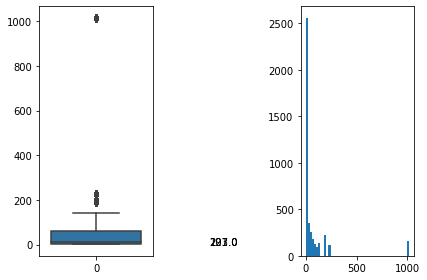

helpful
2 distinct values
False    3824
True     1428
Name: helpful, dtype: int64




In [100]:
USEFULNESS_THRESHOLD = 0.10
#Scale by review votes count divided by total helpful votes of that products
final_data['helpful_votes_scaled'] = final_data['data/helpful_votes'] / final_data['sum']
final_data['helpful'] = np.where(final_data['helpful_votes_scaled'] >= USEFULNESS_THRESHOLD,True,False)
float_cols = ['helpful_votes_scaled','data/helpful_votes','sum']
cat_cols = ['helpful']
visualize_columns(float_cols,cat_cols)

0.005042016806722689
helpful_votes_scaled
[1.0, 0.2873949579831933, 0.16974789915966387]
0.0


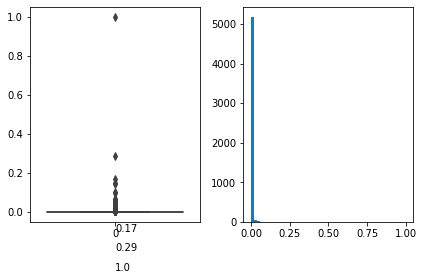

data/helpful_votes
[595, 171, 101]
0


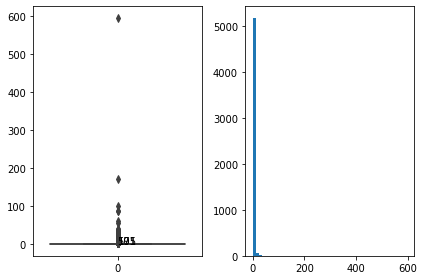

sum
[227.0, 201.0, 193.0]
1.0


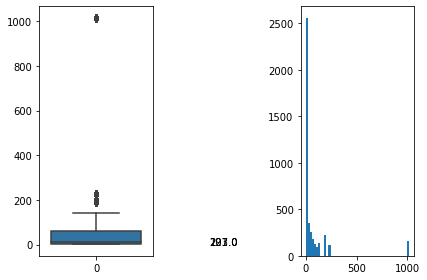

helpful
2 distinct values
False    4587
True      665
Name: helpful, dtype: int64




In [105]:
TOP_K_PERCENT = 10
#Scaled by max-min of dataset
scaler = MinMaxScaler()
final_data['helpful_votes_scaled'] = scaler.fit_transform(final_data[['data/helpful_votes']])
# Find the minimum value of the top K percent records
USEFULNESS_THRESHOLD = np.min(final_data.nlargest(int(len(final_data)*TOP_K_PERCENT/100),'helpful_votes_scaled')['helpful_votes_scaled'])
print(USEFULNESS_THRESHOLD)
final_data['helpful'] = np.where(final_data['helpful_votes_scaled'] >= USEFULNESS_THRESHOLD,True,False)
float_cols = ['helpful_votes_scaled','data/helpful_votes','sum']
cat_cols = ['helpful']
visualize_columns(float_cols,cat_cols)

#Explore topics distribution of sample reviews (1,2 from highly useful and 1,2 from not useful)

In [57]:
final_data.nlargest(5,'data/helpful_votes')

,data/helpful_votes,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_headline,data/review_id,data/star_rating,data/total_votes,count,sum,min,max,helpful_votes_scaled,helpful
3015,595,b'B00C1DEFHI',b'453459277',b'Wilson US Open Junior Tennis Racquet',"b'Nice, affordable, light tennis racquet, but ...","b'Nice Starter Racquet, but Review a Size Chart'",b'R1QLQ05NFCCX2N',4,598,159.0,1016.0,0.0,595.0,1.000000,True
4108,171,b'B00BCP4XKU',b'453459277',b'Wilson US Open Junior Tennis Racquet',b'Great racket for a beginner tennis player. ...,b'Size guidelines',b'RC7BO7IPK6MAM',5,177,159.0,1016.0,0.0,595.0,0.287395,True
2176,101,b'B000OQBP7C',b'384056751',b'Head Liquidmetal 8 Tennis Racquet',"b""Basically, I'm a 58 year old recreational 4....","b'Tried and Liked others costing up to $200., ...",b'R2Q926GXNLNNCY',5,105,117.0,227.0,0.0,101.0,0.169748,True
239,89,b'B000OQ8OU8',b'547332048',b'HEAD Ti.S6 Tennis Racquet - Strung',"b""I was on my high school tennis team almost 4...",b'Outstanding for returning recreational players',b'R3DF8ED26I7Y24',5,92,109.0,201.0,0.0,89.0,0.149580,True
1826,87,b'B00BCP4VJ8',b'453459277',b'Wilson US Open Junior Tennis Racquet',"b""The size of the racket you should buy your c...",b'How to know which size- measure fingertips t...,b'R2ZAS7JMZ6M3YH',5,88,159.0,1016.0,0.0,595.0,0.146218,True


In [83]:
final_data.nsmallest(20,'data/helpful_votes')

,data/helpful_votes,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_headline,data/review_id,data/star_rating,data/total_votes,count,sum,min,max,helpful_votes_scaled,helpful
2,0,b'B006A2V4KC',b'81787317',b'Head Youtek IG Prestige Pro Tennis Racquet (...,"b""I've been playing with Head Racquets for man...",b'Best of the Prestige frames',b'R2NOC0IE7BEWWN',5,0,5.0,8.0,0.0,6.0,0.0,False
3,0,b'B000OQBP7C',b'384056751',b'Head Liquidmetal 8 Tennis Racquet',b'I chose this racquet because its price and w...,b'Great!!!',b'R2IDP12RDJ1SB5',5,1,117.0,227.0,0.0,101.0,0.0,False
6,0,b'B002N1SMOU',b'33077627',b'GAMMA X-2 Tennis Racquet/ Racquet Stringing ...,"b'Easy to use, after stringing second time, I ...",b'Five Stars',b'R1HM2BMVP1POGO',5,1,111.0,193.0,0.0,21.0,0.0,False
7,0,b'B006A2Y30U',b'320145091',b'Head You Tek IG Radical S Tennis Racquet',b'good product<br />single failure: damage a h...,b'Four Stars',b'R2YQZAJZUWFA8X',4,0,5.0,13.0,0.0,9.0,0.0,False
9,0,b'B001ACOF9E',b'664151410',"b""Wilson '08 K BLADE Tour 93 Tennis Racquet-5""","b""This racquet is great for 4.0+ level players...",b'Great for the experienced; Others beware',b'R3MHG6HNOWS3SJ',5,0,NaN,NaN,NaN,NaN,0.0,False
10,0,b'B00CHZZFJC',b'987277405',b'Hello Kitty Sports Junior Tennis Racquet',"b'It was a gift, but came in on time, looked g...",b'looked great.',b'R3SP7QZBVPUN07',5,0,24.0,16.0,0.0,4.0,0.0,False
11,0,b'B0001GZ7O2',b'428353524',b'Dunlop 600G ICE Tennis Racquet',"b'I bought a prince o3 \\\\""red\\\\"" and used ...",b'BEST VALUE RACQUET',b'R3FTJWQS14833D',5,0,NaN,NaN,NaN,NaN,0.0,False
13,0,b'B00FYXG9I0',b'280599633',b'Wilson Pro Staff Junior Tennis Racquet',b'the product is very good',b'Four Stars',b'R3FXXO4FL4ARSG',4,1,8.0,5.0,0.0,4.0,0.0,False
15,0,b'B00387ET9A',b'245257838',b'Wilson Advantage Triple Tennis Racquet Bag (...,b'excellent product',b'Five Stars',b'R2F60NFXA9V4GC',5,0,133.0,81.0,0.0,40.0,0.0,False
17,0,b'B00BCP4XKU',b'453459277',b'Wilson US Open Junior Tennis Racquet',b'Priced great and is super light. Kids loves ...,b'Super light and priced right !',b'R1MGH5G3H0L55V',4,0,159.0,1016.0,0.0,595.0,0.0,False


In [85]:
sample_review_pos_1 = final_data['data/review_body'].iloc[3015]
print(sample_review_pos_1)
sample_review_pos_2 = final_data['data/review_body'].iloc[239]
print(sample_review_pos_2)
sample_review_neg_1 = final_data['data/review_body'].iloc[13]
print(sample_review_neg_1)
sample_review_neg_2 = final_data['data/review_body'].iloc[17]
print(sample_review_neg_2)

b'Nice, affordable, light tennis racquet, but wish the listing would have included (or we would have researched for) a size chart like the image attached (which came with this racquet) since the 19&#34; racquet seems a bit small for even our relatively small 5-year old.'
b"I was on my high school tennis team almost 40 years ago, and the last time I played seriously was about 30 years ago.  Now in my mid-fifties, I wanted to get back in the game for exercise.  My last racquet (remember how long ago this was) was an Arthur Ash Head Comp strung to 63 lbs with VS gut.  I simply love the Head Ti-S6!  I love it's lightness, as it lets me move the head around quickly to make shots I couldn't even make in high school.  It has a lot of power, whether for volleying, or for ground strokes.  The control from the baseline is better than I have ever had, and I can put those baseline shots right over the net with tremendous power.  The synthetic gut the racquet comes with allows quite a good spin, an

In [141]:
MDL = 'model4.gensim'
ldamodel = gensim.models.ldamodel.LdaModel.load(home_dir+MDL)
def return_topics_distribution(document,dictionary=texts_dict,lda=ldamodel):
  clean_doc = tokenize_stop_stem_text(document)
  bow = dictionary.doc2bow(clean_doc)
  new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])
  return new_doc_distribution

In [63]:
print(return_topics_distribution(sample_review_pos_1))
print(return_topics_distribution(sample_review_pos_2))
print(return_topics_distribution(sample_review_neg_1))
print(return_topics_distribution(sample_review_neg_1))

[0.16469537 0.01168004 0.5892447  0.23437987]
[0.2531362  0.47179246 0.0021463  0.27292508]
[0.1106678  0.50239724 0.01038471 0.3765503 ]
[0.11067715 0.50241345 0.01038201 0.37652737]


# Measuring similarity of new review to the trained LDA corpus

In [65]:
# we need to use nested list comprehension here
# this may take 1-2 minutes...
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in ldamodel[corpus]])
doc_topic_dist

array([[0.35308424, 0.10801675, 0.1367207 , 0.4021783 ],
       [0.72101665, 0.0214636 , 0.23446922, 0.02305052],
       [0.8584496 , 0.01818722, 0.1046809 , 0.01868234],
       ...,
       [0.00178836, 0.99453944, 0.00183948, 0.0018327 ],
       [0.02318582, 0.02319025, 0.02319549, 0.93042845],
       [0.00739571, 0.00744607, 0.00735457, 0.9778037 ]], dtype=float32)

In [66]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    sim=[distance.jensenshannon(data,query) for data in matrix]
    return sim

In [67]:
def get_most_similar_documents(query,matrix,k=5):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return np.argsort(sims)[:k] # the top k positional index of the smallest Jensen Shannon distances

# Investigating potential relationships between LDA model predictions and reviews usefulness


In [138]:
USEFULNESS_THRESHOLD = 0.10
#Scale by review votes count divided by total helpful votes of that products
train_df['helpful_votes_scaled'] = train_df['data/helpful_votes'] / train_df['sum']
train_df['helpful'] = np.where(train_df['helpful_votes_scaled'] >= USEFULNESS_THRESHOLD,True,False)

In [139]:
TOP_K_PERCENT = 10
# Apply min-max scaling to train dataset and label the reviews based on threshold
train_df['helpful_votes_scaled'] = scaler.fit_transform(train_df[['data/helpful_votes']])
# Find the minimum value of the top K percent records
USEFULNESS_THRESHOLD = np.min(final_data.nlargest(int(len(train_df)*TOP_K_PERCENT/100),'helpful_votes_scaled')['helpful_votes_scaled'])
print(USEFULNESS_THRESHOLD)
train_df['helpful'] = np.where(train_df['helpful_votes_scaled'] >= USEFULNESS_THRESHOLD,True,False)

0.010084033613445379


In [92]:
new_doc_distribution = return_topics_distribution(sample_review_pos_2)
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)
print(most_sim_ids)
most_similar_df = train_df.iloc[most_sim_ids,:]
most_similar_df

[  87  301  772  248 1107]


,data/helpful_votes,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_headline,data/review_id,data/star_rating,data/total_votes,count,sum,min,max,helpful_votes_scaled,helpful
239,89,b'B000OQ8OU8',b'547332048',b'HEAD Ti.S6 Tennis Racquet - Strung',I was on my high school tennis team almost ye...,b'Outstanding for returning recreational players',b'R3DF8ED26I7Y24',5,92,109.0,201.0,0.0,89.0,0.148148,True
757,2,b'B00GAB9XII',b'167148431',b'Head YouTek Graphene Radical REV Tennis Racq...,I have about racquets but have switched over ...,b'Tennis Elbow Friendly Racquet',b'R3VSO16UF99T7G',4,2,1.0,2.0,2.0,2.0,0.001684,False
1966,6,b'B0030GGXWA',b'525218499',b'Head Micro Gel Radical OS Strung Tennis Racq...,I purchased one of these racquets along with a...,"b'A very nice racquet, especially for the price'",b'R1SA88EANF10Y2',5,7,28.0,43.0,0.0,10.0,0.008418,False
633,9,b'B006A2Y8ZA',b'320145091',b'Head You Tek IG Radical S Tennis Racquet',"Hi every one, my best regards from Sud America...",b'It is the choosen one!!!!',b'R9FPAISDTVXQ0',5,10,5.0,13.0,0.0,9.0,0.013468,True
2788,7,b'B0000AQ9EA',b'804079990',b'Prince Triple Threat Scream Oversize Tennis ...,Am a -. player ..getting back into the game af...,b'Like it a lot!',b'R2TL89QCXNL52P',4,7,5.0,22.0,0.0,15.0,0.010101,True


#Predicting usefulness scores by averging the score of k most similar documents

In [95]:
def predict_usefulness_score(doc):
  new_doc_distribution = return_topics_distribution(doc)
  most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)
  most_sim_df_scores = train_df.iloc[most_sim_ids,:]
  return np.mean(most_sim_df_scores['helpful_votes_scaled'])

In [107]:
print(predict_usefulness_score(sample_review_neg_2))

0.00033670033670033666


In [108]:
#apply to entire data set
final_data['predicted_score'] = final_data['data/review_body'].apply(predict_usefulness_score)
final_data.head(5)

,data/helpful_votes,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_headline,data/review_id,data/star_rating,data/total_votes,count,sum,min,max,helpful_votes_scaled,helpful,predict_score
0,1,b'B000OQ74FE',b'447336068',"b'HEAD Liquidmetal 4 Tennis Racquet (4-3/8), S...","b""Supposedly one of the best novice racquets. ...",b'highly rated',b'R12VYI1R99EI1Q',5,4,22.0,38.0,0.0,10.0,0.001681,False,0.001010
1,1,b'B0034PBLA6',b'16849618',b'Wilson Energy Extra Large Tennis Racquet wit...,b'Wilson Energy Extra Large Tennis Racquet wit...,b'Wilson Energy Extra Large Tennis Racquet wit...,b'R31ZPNKKOSMF2L',3,5,86.0,114.0,0.0,24.0,0.001681,False,0.003030
2,0,b'B006A2V4KC',b'81787317',b'Head Youtek IG Prestige Pro Tennis Racquet (...,"b""I've been playing with Head Racquets for man...",b'Best of the Prestige frames',b'R2NOC0IE7BEWWN',5,0,5.0,8.0,0.0,6.0,0.000000,False,0.003704
3,0,b'B000OQBP7C',b'384056751',b'Head Liquidmetal 8 Tennis Racquet',b'I chose this racquet because its price and w...,b'Great!!!',b'R2IDP12RDJ1SB5',5,1,117.0,227.0,0.0,101.0,0.000000,False,0.001684
4,1,b'B004IA8GL8',b'586581984',"b""Wilson unstrung'11 Blade Lite BLX Tennis Rac...",b'The racket is really nice for $60+. There is...,b'Good racket',b'R2VG95KHXUZG1S',4,1,6.0,6.0,0.0,2.0,0.001681,False,0.001684


In [145]:
#save it
predicted_data = 'US_Tennis_Racquet_Reviews_Predictions.csv'
final_data.to_csv(home_dir+predicted_data)

# Visualize the results

In [4]:
#load saved prediction data. Uncomment if needed
predicted_data = 'US_Tennis_Racquet_Reviews_Predictions.csv'
final_data = pd.read_csv(home_dir+predicted_data)

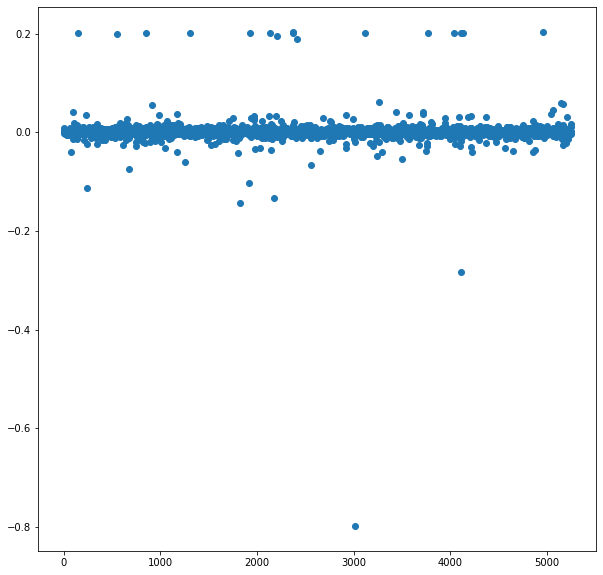

In [29]:
true_vals = final_data['helpful_votes_scaled']
predicted_vals = final_data['predict_score']
plt.figure(figsize=(10,10))
plt.plot(predicted_vals - true_vals,marker='o',linestyle='')
plt.show()

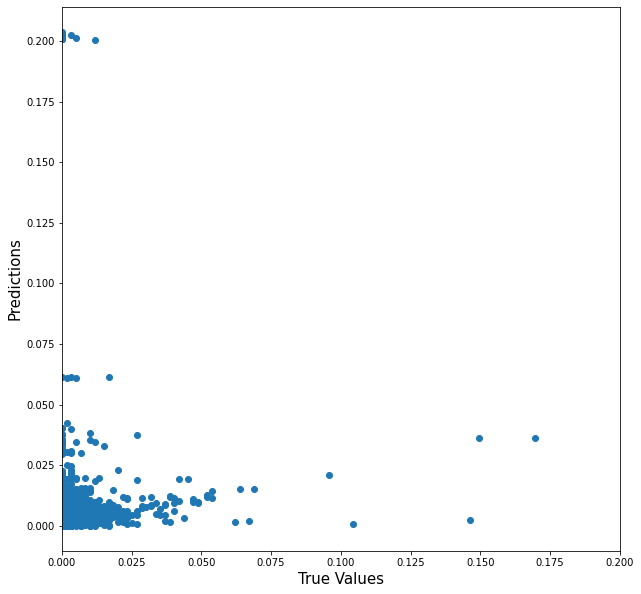

In [6]:
true_vals = final_data['helpful_votes_scaled']
predicted_vals = final_data['predict_score']
plt.figure(figsize=(10,10))
plt.scatter(true_vals, predicted_vals)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.xlim(0,0.2)
plt.show()

In [26]:
CUT_OFF_VALUE = 0.01
final_data['predicted_class'] = np.where(final_data['predict_score'] >= CUT_OFF_VALUE,True,False)
pd.crosstab(final_data['helpful'],final_data['predicted_class'],
            margins_name="Total",rownames=['Actual Class'], colnames=['Predicted Class'],normalize=False)


Predicted Class,False,True
Actual Class,,
False,4407,180
True,592,73


In [27]:
# A cleaner way to report classification metrics
y_test = final_data['helpful']
y_pred = final_data['predicted_class']
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.853008377760853
[[4407  180]
 [ 592   73]]
              precision    recall  f1-score   support

       False       0.88      0.96      0.92      4587
        True       0.29      0.11      0.16       665

    accuracy                           0.85      5252
   macro avg       0.59      0.54      0.54      5252
weighted avg       0.81      0.85      0.82      5252



# Acknowledgement
- https://kldavenport.com/topic-modeling-amazon-reviews/#querying-the-lda-model
- https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
- https://www.kaggle.com/ktattan/lda-and-document-similarity